### Mixed precision Training, TFDS, Data Pipelines
In this Notebook, we use **[Tensorflow Mixed Precision training](https://www.tensorflow.org/guide/mixed_precision)**. That runs faster by taking advantage of float32 and float16 data type operations.
For details go through the documentation. 
For this the GPU should have compute capability of 7.0 or higher. **`Tesla T4`** provided by Google colab has this capability. But if GPU provided by Google colab is other GPU then check the compute capability from (https://developer.nvidia.com/cuda-gpus) 
If Google colab provides some other GPU then can try `Restart Runtime` and see if you can get the Tesla T4 GPU. 

We'll also use **`Tensorflow Dataset (TFDS) `** in this notebook. These are collection of some ready to use Datasets

We'll also create some **Data Pipelines** to create batches of data. Here are some best practices (for details, read: https://www.tensorflow.org/guide/data_performance#best_practice_summary): 
* Use the prefetch transformation to overlap the work of a producer and consumer
* Parallelize the data reading transformation using the interleave transformation
* Parallelize the map transformation by setting the `num_parallel_calls` argument
* Use the cache transformation to cache data in memory during the first epoch
* Vectorize user-defined functions passed in to the `map` transformation
* Reduce memory usage when applying the `interleave`, `prefetch`, and `shuffle` transformations

Use `num_parallel_calls = tf.data.AUTOTUNE` to make use of as many CPUs as available

Downgrading Tensorflow to 2.4.1 below because in TF 2.5+, turning on mixed_precision training results in error for EfficientNet. This is a bug in TF 2.5+

In [2]:
!pip install tensorflow==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 12 kB/s 
     |████████████████████████████████| 3.8 MB 49.8 MB/s 
     |████████████████████████████████| 2.9 MB 45.2 MB/s 
     |████████████████████████████████| 14.8 MB 48.6 MB/s 
     |████████████████████████████████| 462 kB 74.3 MB/s 
     |████████████████████████████████| 132 kB 64.9 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68717 sha256=e0efcaf72890edb315a5e406c79ac09dd4df53486e628e601ae87f96d2d656fb
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: n

In [3]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b6337199-c513-fc8f-49f7-9b01f5d5066e)


In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-11 14:33:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-11 14:33:48 (66.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Download Food101 dataset
(https://www.tensorflow.org/datasets/catalog/food101)

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [8]:
#list all available TFDS
list_datasets = tfds.list_builders()

In [9]:
print("food101" in list_datasets)

True


In [10]:
## Load in Food101 dataset
(train_data, test_data), ds_info = tfds.load(name="food101",
                                          split=['train', 'validation'],
                                          shuffle_files=True,
                                          as_supervised=True,
                                          with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteP5IC77/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteP5IC77/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Explore Food101 TFDS

In [11]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [12]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [13]:
train_data

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [14]:
train_one_sample = train_data.take(1)

In [15]:
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [16]:
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape},
  Image dtype: {image.dtype}
  Class: {label},
  Class Name: {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3),
  Image dtype: <dtype: 'uint8'>
  Class: 16,
  Class Name: cheesecake
  


**Labels are label encoded integers**

In [17]:
image, label, image.shape

(<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
 array([[[ 85,  84,  92],
         [ 86,  85,  93],
         [ 93,  92, 100],
         ...,
         [120, 196, 245],
         [120, 198, 246],
         [121, 199, 247]],
 
        [[ 88,  88,  96],
         [ 82,  82,  90],
         [ 88,  88,  96],
         ...,
         [116, 192, 244],
         [118, 195, 249],
         [119, 196, 248]],
 
        [[ 77,  80,  89],
         [ 75,  78,  87],
         [ 82,  86,  95],
         ...,
         [115, 189, 252],
         [117, 192, 255],
         [118, 194, 255]],
 
        ...,
 
        [[159, 166, 194],
         [154, 161, 187],
         [171, 178, 204],
         ...,
         [219, 216, 235],
         [223, 220, 239],
         [227, 226, 244]],
 
        [[170, 179, 208],
         [169, 179, 206],
         [173, 183, 210],
         ...,
         [218, 217, 235],
         [223, 222, 240],
         [226, 227, 245]],
 
        [[168, 177, 206],
         [170, 179, 208],
         [152,

In [18]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

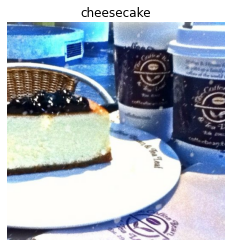

In [19]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)
plt.show();

### Create preprocessing functions for the data
1. The data is in `uint8` format, we need to change it to float to pass it to NN
2. We need to create batches of data 
3. We need to resize the images -> Images in a batch should be of same size
4. We need to rescale the image -> Normalize -> Not needed for `EfficientNet` 

In [20]:
def preprocess_image(image, label, img_size=224):
  """
  Takes an image and label as an input and converts
  image dtype from `uint8` to `float32`. And reshapes 
  image to [img_size, img_size, channels]
  """
  image = tf.image.resize(image, [img_size, img_size])
  return tf.cast(image, tf.float32), label

In [21]:
img, label = preprocess_image(image, label)
print(img.shape)
print(img.dtype)

(224, 224, 3)
<dtype: 'float32'>


In [22]:
image, img

(<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
 array([[[ 85,  84,  92],
         [ 86,  85,  93],
         [ 93,  92, 100],
         ...,
         [120, 196, 245],
         [120, 198, 246],
         [121, 199, 247]],
 
        [[ 88,  88,  96],
         [ 82,  82,  90],
         [ 88,  88,  96],
         ...,
         [116, 192, 244],
         [118, 195, 249],
         [119, 196, 248]],
 
        [[ 77,  80,  89],
         [ 75,  78,  87],
         [ 82,  86,  95],
         ...,
         [115, 189, 252],
         [117, 192, 255],
         [118, 194, 255]],
 
        ...,
 
        [[159, 166, 194],
         [154, 161, 187],
         [171, 178, 204],
         ...,
         [219, 216, 235],
         [223, 220, 239],
         [227, 226, 244]],
 
        [[170, 179, 208],
         [169, 179, 206],
         [173, 183, 210],
         ...,
         [218, 217, 235],
         [223, 222, 240],
         [226, 227, 245]],
 
        [[168, 177, 206],
         [170, 179, 208],
         [152,

### Batching and preparing dataset

In [23]:
## Map preprocessing function and parallelize
train_data = train_data.map(map_func = preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)

## Shuffle train data and map it into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size = tf.data.AUTOTUNE)

## For test data
test_data = test_data.map(map_func = preprocess_image, num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

### Create Modeling callbacks

In [25]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                      monitor = "val_sparse_categorical_accuracy",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 1)

### Setup Mixed Precision Training

In [26]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [27]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Build Feature extraction model

In [28]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name = "input_layer")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avg_pool_2d")(x)

x = tf.keras.layers.Dense(len(class_names), name = "dense_logits")(x)

outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32, name = "predictions")(x) ### This is for numerical stability, becaus we are using mixed_precision

model = tf.keras.Model(inputs, outputs)

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2d (GlobalAv (None, 1280)              0         
_________________________________________________________________
dense_logits (Dense)         (None, 101)               129381    
_________________________________________________________________
predictions (Activation)     (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


### Checking layer dtype policies

In [29]:
for layer in model.layers:
  print(f"{layer.name}\t Trainable: {layer.trainable}\t dtype: {layer.dtype}\t dtype_policy:{layer.dtype_policy}.")

input_layer	 Trainable: True	 dtype: float32	 dtype_policy:<Policy "float32">.
efficientnetb0	 Trainable: False	 dtype: float32	 dtype_policy:<Policy "mixed_float16">.
global_avg_pool_2d	 Trainable: True	 dtype: float32	 dtype_policy:<Policy "mixed_float16">.
dense_logits	 Trainable: True	 dtype: float32	 dtype_policy:<Policy "mixed_float16">.
predictions	 Trainable: True	 dtype: float32	 dtype_policy:<Policy "float32">.


### Features extraction model

In [30]:
history = model.fit(
    train_data,
    epochs = 3,
    validation_data = test_data,
    steps_per_epoch = len(train_data),
    validation_steps = int(0.1*len(test_data)),
    callbacks = [model_checkpoint,
                 create_tensorboard_callback("food_101_all_data", "feature_extraction_mixed_precision_model")]
)

Saving TensorBoard log files to: food_101_all_data/feature_extraction_mixed_precision_model/20220811-144314
Epoch 1/3
2368/2368 [==============================] - 188s 72ms/step - loss: 2.3297 - sparse_categorical_accuracy: 0.4659 - val_loss: 1.2269 - val_sparse_categorical_accuracy: 0.6744

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.67445, saving model to model_checkpoints/cp.ckpt
Epoch 2/3
2368/2368 [==============================] - 178s 75ms/step - loss: 1.3198 - sparse_categorical_accuracy: 0.6601 - val_loss: 1.1312 - val_sparse_categorical_accuracy: 0.6919

Epoch 00002: val_sparse_categorical_accuracy improved from 0.67445 to 0.69185, saving model to model_checkpoints/cp.ckpt
Epoch 3/3
2368/2368 [==============================] - 177s 73ms/step - loss: 1.1580 - sparse_categorical_accuracy: 0.6981 - val_loss: 1.1006 - val_sparse_categorical_accuracy: 0.6919

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.69185


In [31]:
results = model.evaluate(test_data)

790/790 [==============================] - 71s 90ms/step - loss: 1.0922 - sparse_categorical_accuracy: 0.7051


In [46]:
[key for key in list(history.history.keys()) if key.endswith('accuracy') and not key.startswith('val')][0]


'sparse_categorical_accuracy'

In [47]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Accuracy measure:
  acc = [key for key in list(history.history.keys()) if key.endswith('accuracy') and not key.startswith('val')][0]

  accuracy = history.history[acc]
  val_accuracy = history.history['val_' + acc]

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

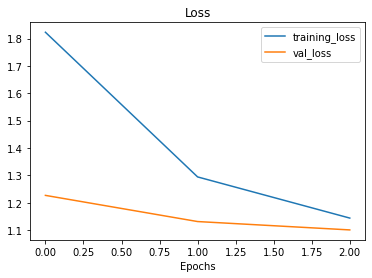

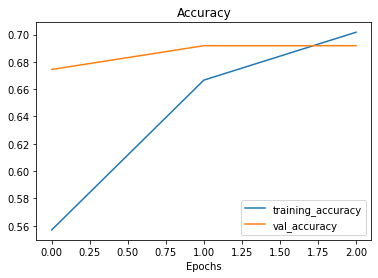

In [48]:
plot_loss_curves(history)

In [49]:
model.save("/content/drive/MyDrive/Colab Notebooks/101_classes_all_data_feature_extractor_model")

### Improving the model with Fine tuning 

#### Unfreeze last 5 layers

In [50]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2d (GlobalAv (None, 1280)              0         
_________________________________________________________________
dense_logits (Dense)         (None, 101)               129381    
_________________________________________________________________
predictions (Activation)     (None, 101)               0         
Total params: 4,178,952
Trainable params: 910,821
Non-trainable params: 3,268,131
_________________________________________________________________


In [51]:
fine_tune_epochs = 6

history2 = model.fit(
    train_data,
    epochs = fine_tune_epochs,
    validation_data = test_data,
    steps_per_epoch = len(train_data),
    validation_steps = int(0.15*len(test_data)),
    initial_epoch = history.epoch[-1],
    callbacks = [create_tensorboard_callback("food_101_all_data",
                                             "fine_tune_last_5_mixed_precision")]
)

Saving TensorBoard log files to: food_101_all_data/fine_tune_last_5_mixed_precision/20220811-150824
Epoch 3/6
2368/2368 [==============================] - 283s 114ms/step - loss: 0.9866 - sparse_categorical_accuracy: 0.7400 - val_loss: 0.9935 - val_sparse_categorical_accuracy: 0.7370
Epoch 4/6
2368/2368 [==============================] - 269s 112ms/step - loss: 0.8328 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.9677 - val_sparse_categorical_accuracy: 0.7346
Epoch 5/6
2368/2368 [==============================] - 270s 113ms/step - loss: 0.7415 - sparse_categorical_accuracy: 0.8041 - val_loss: 0.9655 - val_sparse_categorical_accuracy: 0.7325
Epoch 6/6
2368/2368 [==============================] - 267s 112ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.8250 - val_loss: 0.9490 - val_sparse_categorical_accuracy: 0.7391


In [52]:
results2 = model.evaluate(test_data)

790/790 [==============================] - 82s 104ms/step - loss: 0.9601 - sparse_categorical_accuracy: 0.7405


In [59]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Accuracy measure:
    acc_key = [key for key in list(original_history.history.keys()) if key.endswith('accuracy') and not key.startswith('val')][0]
    # Get original history measurements
    acc = original_history.history[acc_key]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_"+acc_key]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history[acc_key]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_"+acc_key]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  

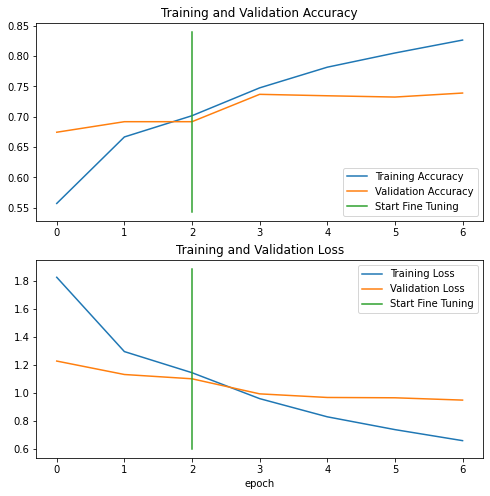

In [60]:
compare_historys(history, history2, initial_epochs=3)

In [62]:
history.epoch

[0, 1, 2]

In [63]:
history2.epoch

[2, 3, 4, 5]

## Lets fine tune all layers 👨

In [65]:
# Refresh model from checkpoint
model.load_weights(checkpoint_path)

In [66]:
# Validate if the model is loaded correctly
model.evaluate(test_data)

790/790 [==============================] - 82s 103ms/step - loss: 1.1289 - sparse_categorical_accuracy: 0.6966


[1.128891944885254, 0.6966336369514465]

In [ ]:
#790/790 [==============================] - 71s 90ms/step - loss: 1.0922 - sparse_categorical_accuracy: 0.7051


In [69]:
base_model.trainable = True

for layer in base_model.layers:
  print(f"""
  {layer.name}\t{layer.trainable}\t{layer.dtype}\t{layer.dtype_policy}
  """)


  input_1	True	float32	<Policy "float32">
  

  rescaling	True	float32	<Policy "mixed_float16">
  

  normalization	True	float32	<Policy "float32">
  

  stem_conv_pad	True	float32	<Policy "mixed_float16">
  

  stem_conv	True	float32	<Policy "mixed_float16">
  

  stem_bn	True	float32	<Policy "mixed_float16">
  

  stem_activation	True	float32	<Policy "mixed_float16">
  

  block1a_dwconv	True	float32	<Policy "mixed_float16">
  

  block1a_bn	True	float32	<Policy "mixed_float16">
  

  block1a_activation	True	float32	<Policy "mixed_float16">
  

  block1a_se_squeeze	True	float32	<Policy "mixed_float16">
  

  block1a_se_reshape	True	float32	<Policy "mixed_float16">
  

  block1a_se_reduce	True	float32	<Policy "mixed_float16">
  

  block1a_se_expand	True	float32	<Policy "mixed_float16">
  

  block1a_se_excite	True	float32	<Policy "mixed_float16">
  

  block1a_project_conv	True	float32	<Policy "mixed_float16">
  

  block1a_project_bn	True	float32	<Policy "mixed_float16">
  

  bloc

In [71]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                   patience = 3
                                                                   )
big_model_checkpoint_path = "model_checkpoints_big_model/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = big_model_checkpoint_path,
                                                      monitor = "val_loss",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 1)

In [72]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2d (GlobalAv (None, 1280)              0         
_________________________________________________________________
dense_logits (Dense)         (None, 101)               129381    
_________________________________________________________________
predictions (Activation)     (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [73]:
fine_tune_epochs = 100

history3 = model.fit(
    train_data,
    epochs = fine_tune_epochs,
    validation_data = test_data,
    steps_per_epoch = len(train_data),
    validation_steps = int(0.15*len(test_data)),
    initial_epoch = history.epoch[-1],
    callbacks = [model_checkpoint, early_stopping_callback,
                 create_tensorboard_callback("food_101_all_data",
                                             "fine_tune_all_layers")]
)

Saving TensorBoard log files to: food_101_all_data/fine_tune_all_layers/20220811-155913
Epoch 3/100
2368/2368 [==============================] - 407s 163ms/step - loss: 1.0529 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7936 - val_sparse_categorical_accuracy: 0.7810

Epoch 00003: val_loss improved from inf to 0.79362, saving model to model_checkpoints_big_model/cp.ckpt
Epoch 4/100
2368/2368 [==============================] - 381s 159ms/step - loss: 0.6498 - sparse_categorical_accuracy: 0.8209 - val_loss: 0.7435 - val_sparse_categorical_accuracy: 0.7966

Epoch 00004: val_loss improved from 0.79362 to 0.74348, saving model to model_checkpoints_big_model/cp.ckpt
Epoch 5/100
2368/2368 [==============================] - 381s 160ms/step - loss: 0.3692 - sparse_categorical_accuracy: 0.8959 - val_loss: 0.8198 - val_sparse_categorical_accuracy: 0.7961

Epoch 00005: val_loss did not improve from 0.74348
Epoch 6/100
2368/2368 [==============================] - 380s 159ms/step - loss: 0.18

In [74]:
results3 = model.evaluate(test_data)

790/790 [==============================] - 101s 128ms/step - loss: 1.0780 - sparse_categorical_accuracy: 0.7681


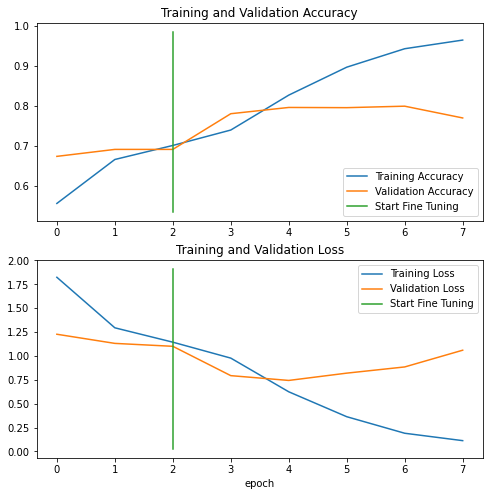

In [75]:
compare_historys(history, history3, initial_epochs=3)

## Refresh the model from the one where it was checkpointed. After that it loss started increasing

In [76]:
model.load_weights(big_model_checkpoint_path)

In [77]:
model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 0.7459 - sparse_categorical_accuracy: 0.7949


[0.745898962020874, 0.7948910593986511]

## We have beaten the DeepFood paper (https://arxiv.org/pdf/1606.05675.pdf)

In [78]:
model.save("101_classes_all_data_fine_tuned_model")